In [5]:
import os
import geopandas as gpd
import requests
import pandas as pd
import matplotlib.pyplot as plt

   HARGA PROPERTI NET (RP)  jarak_pendidikan  jarak_kesehatan  \
0                430000000        973.410428       288.961635   
1                400000000       1089.797546      1360.069963   
2                350000000        350.469126       293.587034   
3              13000000000        273.662924       227.685814   
4              16000000000        633.879055      1161.574071   

   jarak_transportasi KELAS_RISIKO  SKOR_TOTAL  
0          442.520672       TINGGI         9.0  
1          806.809194          NaN        10.0  
2         1584.505194       TINGGI        10.0  
3         3265.916510       TINGGI        10.0  
4          349.934548       TINGGI         7.0  


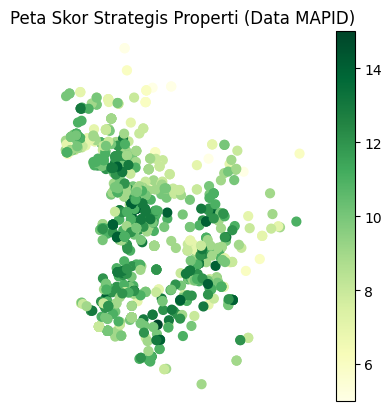

Index(['geometry', 'id', 'ID GRID', 'NAMA PROPERTI', 'TIPE_1', 'TIPE_2',
       'TIPE_3', 'DEVELOPER', 'ALAMAT', 'JUMLAH KAMAR TIDUR', 'SERTIFIKAT',
       'HARGA TANAH MINIMUM (RP/M²)', 'HARGA TANAH MAKSIMUM (RP/M²)',
       'HARGA PROPERTI MINIMUM (RP)', 'HARGA PROPERTI MAKSIMUM (RP)',
       'HARGA TANAH NET (RP/M²)', 'HARGA PROPERTI NET (RP)', 'LUAS TANAH (M²)',
       'LUAS BANGUNAN (M²)', 'STATUS', 'ID_PROV_left', 'PROVINSI_left',
       'ID_KABKOT_left', 'KABKOT_left', 'ID_KEC_left', 'KECAMATAN_left',
       'ID_DESA_left', 'DESA_left', 'LATITUDE', 'LONGITUDE', 'WAKTU',
       'jarak_pendidikan', 'jarak_kesehatan', 'jarak_transportasi',
       'index_right', 'ID_PROV_right', 'PROVINSI_right', 'ID_KABKOT_right',
       'KABKOT_right', 'ID_KEC_right', 'KECAMATAN_right', 'ID_DESA_right',
       'DESA_right', 'KELAS_RISIKO', 'SKOR_HARGA', 'SKOR_JARAK_PENDIDIKAN',
       'SKOR_JARAK_KESEHATAN', 'SKOR_JARAK_TRANSPORTASI', 'SKOR_BANJIR',
       'SKOR_TOTAL'],
      dtype='object')


In [ ]:
#GET API
urls ={
    "Properti":"https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68fb8f3a96b90db738e31ad5&project_id=68f488c244612b4d22ec2f83&limit=10000",
    "Pendidikan" :"https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68fb8f99c8804625c613cd3c&project_id=68f488c244612b4d22ec2f83&limit=10000",
    "Kesehatan" :"https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68fb8f6096b90db738e31ee9&project_id=68f488c244612b4d22ec2f83&limit=10000",
    "Transportasi":"https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68fb8f75c8804625c613cc1b&project_id=68f488c244612b4d22ec2f83&limit=10000",
    "Banjir":"https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68fb8fbec8804625c613d261&project_id=68f488c244612b4d22ec2f83&limit=10000"
}

# 2. FUNGSI UNTUK AMBIL DATA DARI URL
# -----------------------------
def get_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        geojson_data = response.json()
        gdf = gpd.GeoDataFrame.from_features(geojson_data["features"])
        return gdf
    else:
        print(f"Gagal mengambil data dari {url}")
        return gpd.GeoDataFrame()

# 3. BACA SEMUA DATA DARI API
# -----------------------------
gdf_properti = get_data(urls["Properti"])
gdf_pendidikan = get_data(urls["Pendidikan"])
gdf_kesehatan = get_data(urls["Kesehatan"])
gdf_transportasi = get_data(urls["Transportasi"])
gdf_banjir = get_data(urls["Banjir"])

# 4. SAMAKAN SISTEM KOORDINAT
# Set CRS dulu sebelum to_crs
gdf_properti.set_crs(epsg=4326, inplace=True)
gdf_pendidikan.set_crs(epsg=4326, inplace=True)
gdf_kesehatan.set_crs(epsg=4326, inplace=True)
gdf_transportasi.set_crs(epsg=4326, inplace=True)
gdf_banjir.set_crs(epsg=4326, inplace=True)

# Proyeksikan ke meter dulu (Web Mercator)
gdf_properti = gdf_properti.to_crs(epsg=3857)
gdf_pendidikan = gdf_pendidikan.to_crs(epsg=3857)
gdf_kesehatan = gdf_kesehatan.to_crs(epsg=3857)
gdf_transportasi = gdf_transportasi.to_crs(epsg=3857)
gdf_banjir = gdf_banjir.to_crs(epsg=3857)

# 5. HITUNG JARAK PROPERTI KE FASILITAS
# -----------------------------
def jarak_terdekat(point, fasilitas):
    return fasilitas.distance(point).min()

gdf_properti["jarak_pendidikan"] = gdf_properti.geometry.apply(lambda x: jarak_terdekat(x, gdf_pendidikan))
gdf_properti["jarak_kesehatan"] = gdf_properti.geometry.apply(lambda x: jarak_terdekat(x, gdf_kesehatan))
gdf_properti["jarak_transportasi"] = gdf_properti.geometry.apply(lambda x: jarak_terdekat(x, gdf_transportasi))

# 6. SPATIAL JOIN UNTUK RISIKO BANJIR
# -----------------------------
gdf_joined = gpd.sjoin(gdf_properti, gdf_banjir, predicate="within", how="left")

# 7. BUAT SKOR UNTUK SETIAP ASPEK
# -----------------------------
# Pastikan kolom harga ada (ubah namanya kalau beda)
kolom_harga = "HARGA PROPERTI NET (RP)" if "HARGA PROPERTI NET (RP)" in gdf_joined.columns else gdf_joined.columns[0]
gdf_joined["SKOR_HARGA"] = pd.qcut(gdf_joined[kolom_harga], q=3, labels=[3, 2, 1]).astype(int)

for col in ["jarak_pendidikan", "jarak_kesehatan", "jarak_transportasi"]:
    gdf_joined[f"SKOR_{col.upper()}"] = pd.qcut(
        gdf_joined[col], q=3, labels=[3, 2, 1]
    ).astype(int)

gdf_joined["SKOR_BANJIR"] = (
    gdf_joined["KELAS_RISIKO"]
    .astype(str)
    .str.upper()
    .map({"RENDAH": 3, "SEDANG": 2, "TINGGI": 1})
    .fillna(3))

# 8. HITUNG SKOR TOTAL
# -----------------------------
gdf_joined["SKOR_TOTAL"] = (
    gdf_joined["SKOR_HARGA"]
    + gdf_joined["SKOR_JARAK_PENDIDIKAN"]
    + gdf_joined["SKOR_JARAK_KESEHATAN"]
    + gdf_joined["SKOR_JARAK_TRANSPORTASI"]
    + gdf_joined["SKOR_BANJIR"]
)

# 9. CETAK & VISUALISASI HASIL
# -----------------------------
print(gdf_joined[[
    kolom_harga,
    "jarak_pendidikan",
    "jarak_kesehatan",
    "jarak_transportasi",
    "KELAS_RISIKO",
    "SKOR_TOTAL"
]].head())

gdf_joined.plot(column="SKOR_TOTAL", cmap="YlGn", legend=True, markersize=40)
plt.title("Peta Skor Strategis Properti (Data MAPID)")
plt.axis("off")
plt.show()

# 10. Export hasil ke GeoJSON untuk QGIS
output_path = r"D:\BOOTCAMP MAPID\Final Project\hasil_skor_properti.geojson"

# Pastikan CRS kembali ke WGS84 biar QGIS gak salah baca lokasi
gdf_export = gdf_joined.to_crs(epsg=4326)

gdf_export.to_file(output_path, driver="GeoJSON", encoding="utf-8")

print(f"File berhasil disimpan: {output_path}")




In [ ]:
# =====================================================
# ANALISIS STRATEGIS PROPERTI BERBASIS DATA SPASIAL (MAPID)
# =====================================================

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import requests

# -----------------------------
# 1. URL SEMUA LAYER DARI MAPID
# -----------------------------
urls = {
    "Properti": "https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68fb8f3a96b90db738e31ad5&project_id=68f488c244612b4d22ec2f83&limit=10000",
    "Pendidikan": "https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68fb8f99c8804625c613cd3c&project_id=68f488c244612b4d22ec2f83&limit=10000",
    "Kesehatan": "https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68fb8f6096b90db738e31ee9&project_id=68f488c244612b4d22ec2f83&limit=10000",
    "Transportasi": "https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68fb8f75c8804625c613cc1b&project_id=68f488c244612b4d22ec2f83&limit=10000",
    "Banjir": "https://geoserver.mapid.io/layers_new/get_layer?api_key=5249521c14de436ebcf1fb8f05e6048d&layer_id=68fb8fbec8804625c613d261&project_id=68f488c244612b4d22ec2f83&limit=10000"
}

# -----------------------------
# 2. FUNGSI UNTUK AMBIL DATA DARI URL
# -----------------------------
def get_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        geojson_data = response.json()
        gdf = gpd.GeoDataFrame.from_features(geojson_data["features"])
        return gdf
    else:
        print(f"Gagal mengambil data dari {url}")
        return gpd.GeoDataFrame()

# -----------------------------
# 3. BACA SEMUA DATA DARI API
# -----------------------------
gdf_properti = get_data(urls["Properti"])
gdf_pendidikan = get_data(urls["Pendidikan"])
gdf_kesehatan = get_data(urls["Kesehatan"])
gdf_transportasi = get_data(urls["Transportasi"])
gdf_banjir = get_data(urls["Banjir"])

# -----------------------------
# 4. SAMAKAN SISTEM KOORDINAT
# -----------------------------
gdf_properti = gdf_properti.to_crs(gdf_banjir.crs)
gdf_pendidikan = gdf_pendidikan.to_crs(gdf_banjir.crs)
gdf_kesehatan = gdf_kesehatan.to_crs(gdf_banjir.crs)
gdf_transportasi = gdf_transportasi.to_crs(gdf_banjir.crs)

# -----------------------------
# 5. HITUNG JARAK PROPERTI KE FASILITAS
# -----------------------------
def jarak_terdekat(point, fasilitas):
    return fasilitas.distance(point).min()

gdf_properti["jarak_pendidikan"] = gdf_properti.geometry.apply(lambda x: jarak_terdekat(x, gdf_pendidikan))
gdf_properti["jarak_kesehatan"] = gdf_properti.geometry.apply(lambda x: jarak_terdekat(x, gdf_kesehatan))
gdf_properti["jarak_transportasi"] = gdf_properti.geometry.apply(lambda x: jarak_terdekat(x, gdf_transportasi))

# -----------------------------
# 6. SPATIAL JOIN UNTUK RISIKO BANJIR
# -----------------------------
gdf_joined = gpd.sjoin(gdf_properti, gdf_banjir, predicate="within", how="left")

# -----------------------------
# 7. BUAT SKOR UNTUK SETIAP ASPEK
# -----------------------------
# Pastikan kolom harga ada (ubah namanya kalau beda)
kolom_harga = "HARGA PROPERTI NET (RP)" if "HARGA PROPERTI NET (RP)" in gdf_joined.columns else gdf_joined.columns[0]
gdf_joined["SKOR_HARGA"] = pd.qcut(gdf_joined[kolom_harga], q=3, labels=[3, 2, 1]).astype(int)

for col in ["jarak_pendidikan", "jarak_kesehatan", "jarak_transportasi"]:
    gdf_joined[f"SKOR_{col.upper()}"] = pd.qcut(
        gdf_joined[col], q=3, labels=[3, 2, 1]
    ).astype(int)

gdf_joined["SKOR_BANJIR"] = (
    gdf_joined["KELAS_RISIKO"]
    .astype(str)
    .str.upper()
    .map({"RENDAH": 3, "SEDANG": 2, "TINGGI": 1})
    .fillna(3)
)

# -----------------------------
# 8. HITUNG SKOR TOTAL
# -----------------------------
gdf_joined["SKOR_TOTAL"] = (
    gdf_joined["SKOR_HARGA"]
    + gdf_joined["SKOR_JARAK_PENDIDIKAN"]
    + gdf_joined["SKOR_JARAK_KESEHATAN"]
    + gdf_joined["SKOR_JARAK_TRANSPORTASI"]
    + gdf_joined["SKOR_BANJIR"]
)

# -----------------------------
# 9. CETAK & VISUALISASI HASIL
# -----------------------------
print(gdf_joined[[
    kolom_harga,
    "jarak_pendidikan",
    "jarak_kesehatan",
    "jarak_transportasi",
    "KELAS_RISIKO",
    "SKOR_TOTAL"
]].head())

gdf_joined.plot(column="SKOR_TOTAL", cmap="YlGn", legend=True, markersize=40)
plt.title("Peta Skor Strategis Properti (Data MAPID)")
plt.axis("off")
plt.show()
